In [7]:
import multimod_dbn as DBN
import torch
import dataset_v1
from torchvision import transforms
import IPython

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
batch_size = 32
'''data_path = '/home/emmv1d18/Work/Databases/1_object_256x256_uniform_density_v2/'
dset= dataset.dataset(data_path=data_path,
                          data_type='test',
                           transform=transforms.Compose([
                               dataset.Normalize()
                           ]))'''
data_path = '/home/emmv1d18/Work/Databases/2_objects_256x256_uniform_density/'
dset= dataset.dataset(data_path=data_path,
                          data_type='train',
                           transform=transforms.Compose([
                               dataset.Normalize()
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size,shuffle=True)

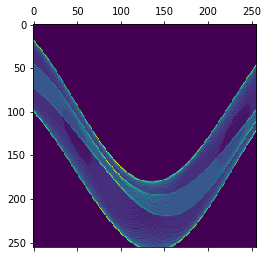

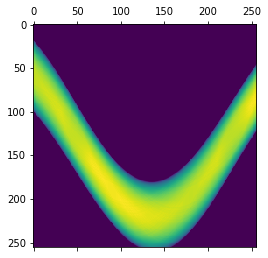

In [9]:
data = next(iter(dataloader))
obj = data['object']
cad = data['cad']
plt.matshow(cad[0][0])
plt.matshow(obj[0][0])

In [11]:
dbn = DBN.multimod_dbn(name='test', number_of_modalities=1)

dbn.add_layer(name='rbm_obj_0', type='convolutional', modality =0, gaussian_units = True, visible_units  = [1,256,256],  f_height = 2, f_width = 2, f_number = 40, c_factor =2)
dbn.add_layer(name='rbm_obj_1', type='convolutional', modality =0, gaussian_units = True, visible_units  = [40,128,128], f_height = 1, f_width = 1, f_number = 20, c_factor =1)
'''dbn.add_layer(name='rbm_obj_2', type='convolutional', modality =0, gaussian_units = True, visible_units  = [80,124,124], f_height = 2, f_width = 2, f_number = 120, c_factor =2)
dbn.add_layer(name='rbm_obj_3', type='convolutional', modality =0, gaussian_units = True, visible_units  = [120,62,62],  f_height = 5, f_width = 5, f_number = 240, c_factor =1)
dbn.add_layer(name='rbm_obj_4', type='convolutional', modality =0, gaussian_units = True, visible_units  = [240,58,58],  f_height = 2, f_width = 2, f_number = 280, c_factor =2)'''

'''dbn.add_layer(name='rbm_cad_0', type='convolutional', modality =1, gaussian_units = True, visible_units  = [1,256,256],  f_height = 2, f_width = 2, f_number = 40, c_factor =2)
dbn.add_layer(name='rbm_cad_1', type='convolutional', modality =1, gaussian_units = True, visible_units  = [40,128,128], f_height = 5, f_width = 5, f_number = 80, c_factor =1)
dbn.add_layer(name='rbm_cad_2', type='convolutional', modality =1, gaussian_units = True, visible_units  = [80,124,124], f_height = 2, f_width = 2, f_number = 120, c_factor =2)
dbn.add_layer(name='rbm_cad_3', type='convolutional', modality =1, gaussian_units = True, visible_units  = [120,62,62],  f_height = 5, f_width = 5, f_number = 240, c_factor =1)
dbn.add_layer(name='rbm_cad_4', type='convolutional', modality =1, gaussian_units = True, visible_units  = [240,58,58],  f_height = 2, f_width = 2, f_number = 280, c_factor =2)'''

#dbn.add_layer(name='joint', type='joint', gaussian_units = [True, True], visible_units = [[280,29,29], [280,29,29]], filter_properties =[[140,1,1], [140,1,1]], hidden_units = [140,29,29] )
#dbn.add_layer(name='joint', type='joint', gaussian_units = [True, True], visible_units = [[40,128,128], [40,128,128]], filter_properties =[[20,1,1], [20,1,1]], hidden_units = [20,128,128] )

dbn.initialise_layer(layer_name='rbm_obj_0',  modality='0', load_path='./saves_new_architecture/rbm0_obj_2x2x2x40')
dbn.initialise_layer(layer_name='rbm_obj_1',  modality='0', load_path='./saves_new_architecture/rbm1_obj_1x1x1x20')
'''dbn.initialise_layer(layer_name='rbm_obj_1',  modality='0', load_path='./saves_thomas/rbm1_5x5x1x80')
dbn.initialise_layer(layer_name='rbm_obj_2',  modality='0', load_path='./saves_thomas/rbm2_2x2x2x120')
dbn.initialise_layer(layer_name='rbm_obj_3',  modality='0', load_path='./saves_thomas/rbm3_5x5x1x240')
dbn.initialise_layer(layer_name='rbm_obj_4',  modality='0', load_path='./saves_thomas/rbm4_2x2x2x280_')'''

#dbn.initialise_layer(layer_name='rbm_cad_0',  modality='1', load_path='./saves_thomas/rbm0_2x2')
'''dbn.initialise_layer(layer_name='rbm_cad_1',  modality='1', load_path='./saves_thomas/rbm1_5x5x1x80')
dbn.initialise_layer(layer_name='rbm_cad_2',  modality='1', load_path='./saves_thomas/rbm2_2x2x2x120')
dbn.initialise_layer(layer_name='rbm_cad_3',  modality='1', load_path='./saves_thomas/rbm3_5x5x1x240')
dbn.initialise_layer(layer_name='rbm_cad_4',  modality='1', load_path='./saves_thomas/rbm4_2x2x2x280_')'''
#dbn.initialise_layer(layer_name='joint', load_path='./saves_thomas/rbm_joint_')
dbn.move_network_to_device(1)

lr = 1e-7
dbn.train_layer(layer_name='rbm_obj_1', dataloader=dataloader, data_names=['object'], run_name='./runs_new_architecture/rbm1_1x1x1x20', save_path='./saves_new_architecture/rbm1_1x1x1x20', 
                epochs=50, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
'''
dbn.train_layer(layer_name='rbm_obj_2', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm2_2x2x2x120_', save_path='./saves_thomas/rbm2_2x2x2x120_', 
                epochs=10, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
dbn.train_layer(layer_name='rbm_obj_3', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm3_5x5x1x240', save_path='./saves_thomas/rbm3_5x5x1x240', 
                epochs=10, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
dbn.train_layer(layer_name='rbm_obj_4', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm4_2x2x2x280_', save_path='./saves_thomas/rbm4_2x2x2x280_', 
                epochs=25, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
dbn.train_layer(layer_name='rbm_obj_5', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm5_4x4x1x560_', save_path='./saves_thomas/rbm5_4x4x1x560', 
                epochs=10, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)

dbn.train_layer(layer_name='rbm_obj_6', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm6_2x2x2x600', save_path='./saves_thomas/rbm6_2x2x2x600', 
                epochs=10, CD_k=1, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)

dbn.train_layer(layer_name='rbm_obj_7', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm7_1x1x1x300', save_path='./saves_thomas/rbm7_1x1x1x300', 
                epochs=5, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
           
dbn.train_layer(layer_name='rbm_obj_8', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm8_1x1x1x50', save_path='./saves_thomas/rbm8_1x1x1x50', 
                epochs=10, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)

dbn.train_layer(layer_name='rbm_obj_9', dataloader=dataloader, data_names=['object'], run_name='./run_strided_thomas/rbm9_2535x1000', save_path='./saves_thomas/rbm9_2535x1000', 
                epochs=30, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)

dbn.train_layer(layer_name='joint', dataloader=dataloader, data_names=['object', 'cad'], run_name='./run_strided_thomas/rbm_joint_bold', save_path='./saves_thomas/rbm_joint_bold', 
                epochs=1, CD_k=10, learning_rate=lr, momentum=0.9, weight_decay=lr, modality = 0)
'''

In [ ]:
obj = obj[0].view((1,1,256,256))
cad = cad[0].view((1,1,256,256))
zeros = torch.zeros((1,1,256,256))

In [ ]:
def res(t):
    return (t-t.mean())/t.std()

In [ ]:
h0_obj = dbn.modalities['0']['rbm_obj_0'].get_hidden_probability([obj.cuda(1).float()])
out_0_obj = dbn.modalities['0']['rbm_obj_0'].top_bottom(res(h0_obj[0]))
h0_obj_ = h0_obj[0].detach().cpu()
out_0_obj_ = out_0_obj.detach().cpu()

In [ ]:
h1_obj = dbn.modalities['0']['rbm_obj_1'].get_hidden_probability(h0_obj)
out_1_obj = dbn.modalities['0']['rbm_obj_1'].top_bottom(res(h1_obj[0]))
h1_obj_ = h1_obj[0].detach().cpu()
out_1_obj_ = out_1_obj.detach().cpu()

In [ ]:
fig=plt.figure(figsize=(16, 16))
columns = 10
rows = 4
for i in range(1, (columns*rows) -1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(h0_obj_[0][i])
plt.show()
plt.matshow(out_0_obj_[0][0])

In [ ]:
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 4
for i in range(1, (columns*rows) -1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(h1_obj_[0][i])
plt.show()
plt.matshow(out_1_obj_[0][0])

In [ ]:
outputs = dbn.network_inference([obj.cuda(1).float()])
obj_ = outputs[0].detach().cpu().view(256,256)
plt.matshow(obj_)


In [ ]:
w0 = dbn.modalities['0']['rbm_obj_0'].parameters['weights'].detach().cpu()
w1 = dbn.modalities['0']['rbm_obj_1'].parameters['weights'].detach().cpu()

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 4
for i in range(1, (columns*rows) -1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(w0[i][0])
plt.show()

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 2
for i in range(1, (columns*rows) -1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(w1[i][0])
plt.show()

In [ ]:
p_h, h = dbn.study_code([obj.cuda(1).float(), cad.cuda(1).float()])
plt.matshow(p_h[0][10])
plt.matshow(h[0][0])

In [ ]:
p_h, h = dbn.study_code([zeros.cuda(1).float(), cad.cuda(1).float()])
plt.matshow(p_h[0][0])
plt.matshow(h[0][0])

In [ ]:
p_h, h = dbn.study_code([obj.cuda(1).float(), zeros.cuda(1).float()])
plt.matshow(p_h[0][0])
plt.matshow(h[0][0])